# DeepFake Detection: ResNet Model

**Objective**: Use transfer learning for feature extraction with ResNet50 followed by Random Forest classification model  

**ResNet 50 Models**: 
1. Binary Classification
2. Multi-Class Classification

In [1]:
import numpy as np
import pandas as pd
% matplotlib inline
from __future__ import print_function

#Data Processing
from skimage import io
import os
import glob
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import random
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Model

from sklearn.svm import SVC
import sklearn

#Neural Networks
from tensorflow.python import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras import optimizers
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


#Models
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

#Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint,Callback
from sklearn import metrics
from tensorflow.keras.models import load_model
import pickle

Using TensorFlow backend.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-pa

## Dataset Split

Load the DeepFake dataset to randomly divide it into train and test set 

In [2]:
# path to your dataset
DATASET_PATH = '/mnt/disks/user/project/Dataset/'
deepfake_class = ['original/clean_frames','FaceSwap/clean_frames', 'Reenactment/clean_frames']

In [3]:
'''
func: load the deepfake dataset and divide them into train and test with each having samples of the different classes
input:
    i.dataset_path: string: the main dataset folder path 
    ii.train_ratio: float: the ratio of the dataset that will be used for training the model. Eg: 0.8
    iii. fake_class: string array: the different deepfake classes
output:
    i. train_set, test_set: dictionary of image paths as key and deepfake class as value
    ii. X_train, X_test: array of image paths 
    iii. y_train, y_test: array of corresponding deepfake classes 
'''
def MultiDatasetSplit(DATASET_PATH, train_ratio,fake_cls):
    test_set = {}
    train_set = {}
    list_IDs = []
    labels = {}
    for i, cls in enumerate(fake_cls):
        paths = glob.glob(os.path.join(DATASET_PATH, cls,'*/*.jpg'))
        #balancing the dataset
        balance_paths = random.sample(paths,2000)

        brk_point = int(len(balance_paths)*train_ratio)
        for j in range(len(balance_paths)):
            if j <= brk_point:
                train_set.update({balance_paths[j]:i})
            else:
                test_set.update({balance_paths[j]:i})
    
    X_train = [X for X in train_set.keys()] 
    y_train = [y for y in train_set.values()]
    X_test = [X for X in test_set.keys()]
    y_test = [y for y in test_set.values()]
    return train_set, test_set, X_train,y_train, X_test, y_test

In [4]:
'''
func: load the deepfake dataset and divide them into train and test with each having samples of the different classes
input:
    i.dataset_path: string: the main dataset folder path 
    ii.train_ratio: float: the ratio of the dataset that will be used for training the model. Eg: 0.8
    iii. fake_class: string array: the different deepfake classes
output:
    i. train_set, test_set: dictionary of image paths as key and deepfake class as value
    ii. X_train, X_test: array of image paths 
    iii. y_train, y_test: array of corresponding deepfake classes 
'''
def BinaryDatasetSplit(DATASET_PATH, train_ratio,fake_cls):
    test_set = {}
    train_set = {}
    list_IDs = []
    labels = {}
    for i, cls in enumerate(fake_cls):
        paths = glob.glob(os.path.join(DATASET_PATH, cls,'*/*.jpg'))
        if i == 0:
            paths = random.sample(paths,4000)
        else:
            paths = random.sample(paths,2000)
        brk_point = int(len(paths)*train_ratio)
        for j in range(len(paths)):
            if j <= brk_point:
                if i == 0:
                    train_set.update({paths[j]:0})
                else: 
                    train_set.update({paths[j]:1})
            else:
                if i == 0:
                    test_set.update({paths[j]:0})
                else:
                    test_set.update({paths[j]:1})

    X_train = [X for X in train_set.keys()] 
    y_train = [y for y in train_set.values()]
    X_test = [X for X in test_set.keys()]
    y_test = [y for y in test_set.values()]
    return train_set, test_set, X_train,y_train, X_test, y_test

In [5]:
b_train_set, b_test_set, b_train_X, b_train_y, b_test_X, b_test_y = BinaryDatasetSplit(DATASET_PATH,0.7,deepfake_class)

In [6]:
m_train_set, m_test_set, m_train_X, m_train_y, m_test_X, m_test_y = MultiDatasetSplit(DATASET_PATH,0.7,deepfake_class)

In [7]:
Counter(b_train_set.values())

Counter({0: 2801, 1: 2802})

In [8]:
Counter(m_train_set.values())

Counter({0: 1401, 1: 1401, 2: 1401})

In [9]:
set(b_test_set.values())

{0, 1}

In [10]:
set(m_test_set.values())

{0, 1, 2}

In [11]:
# specify image size and channels
img_channels = 3
img_rows = 224
img_cols = 224

# number of classes
b_nb_classes = 2
m_nb_classes = 3

## ResNet Feature Extractor

In [ ]:
base_model = ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
base_model.summary()

94658560/94653016 [==============================] - 7s 0us/step


In [13]:
res_model = Model(inputs=base_model.input, outputs=base_model.output)

In [14]:
# train_X = random.sample(b_train_X, 200)
# train_set = {image: b_train_set[image] for image in b_train_X }

In [15]:
# test_X = random.sample(b_test_X, 100)
# test_set = {image: b_test_set[image] for image in b_test_X }

In [16]:
#scaler = sklearn.preprocessing.StandardScaler()

In [17]:
def FeatureExtraction(train_X, train_set):
    
    features = []
    labels = []
    
    for i, image_path in enumerate(train_X):
        img = image.load_img(image_path, target_size=(224,224))
        img_array = image.img_to_array(img)
        #img = img/255
        img = np.expand_dims(img_array, axis=0)
        img_process = preprocess_input(img)
        feature = res_model.predict(img_process)
        flat = feature.flatten()
        features.append(flat)
        label = train_set[image_path]
        labels.append(label)
        if (i % 100) == 0:
            print('On image',i)
            #print(img_process)
    le = LabelEncoder()
    y_value = le.fit_transform(labels)
    return features, y_value

In [18]:
features, labels = FeatureExtraction(b_train_X, b_train_set)

On image 0
On image 100
On image 200
On image 300
On image 400
On image 500
On image 600
On image 700
On image 800
On image 900
On image 1000
On image 1100
On image 1200
On image 1300
On image 1400
On image 1500
On image 1600
On image 1700
On image 1800
On image 1900
On image 2000
On image 2100
On image 2200
On image 2300
On image 2400
On image 2500
On image 2600
On image 2700
On image 2800
On image 2900
On image 3000
On image 3100
On image 3200
On image 3300
On image 3400
On image 3500
On image 3600
On image 3700
On image 3800
On image 3900
On image 4000
On image 4100
On image 4200
On image 4300
On image 4400
On image 4500
On image 4600
On image 4700
On image 4800
On image 4900
On image 5000
On image 5100
On image 5200
On image 5300
On image 5400
On image 5500
On image 5600


## Binary ResNet Random Forest Model

In [19]:
rfc = RandomForestClassifier()
rfc.fit(features,labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
rfc.score(features,labels)

0.9862573621274318

### Hyperparameter training

In [23]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(features,labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(2, 20, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [24]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/disks/user/anacon

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.300185,0.004299,0.006121,0.000217,2,{'max_depth': 2},0.532977,0.467440,0.530357,0.559821,...,0.530609,0.034254,4,0.601428,0.605979,0.600268,0.587999,0.604506,0.600036,0.006359
1,0.851659,0.007015,0.006994,0.000256,7,{'max_depth': 7},0.532977,0.525424,0.557143,0.567857,...,0.545065,0.015536,2,0.831064,0.825301,0.835601,0.829801,0.823779,0.829109,0.004228
2,1.237763,0.027604,0.007904,0.000288,12,{'max_depth': 12},0.554367,0.528100,0.560714,0.573214,...,0.561306,0.020623,1,0.963624,0.962517,0.963417,0.956948,0.966986,0.962699,0.003251
3,1.380969,0.034639,0.008164,0.000254,17,{'max_depth': 17},0.553476,0.530776,0.552679,0.545536,...,0.544530,0.008434,3,0.987726,0.987729,0.984385,0.983716,0.982824,0.985276,0.002062


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


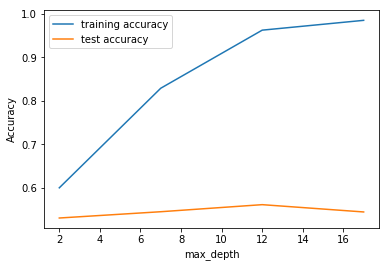

In [25]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [26]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(features,labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(100, 1500, 400)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [27]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/disks/user/anacon

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.177037,0.028326,0.024763,0.000618,100,{'n_estimators': 100},0.537433,0.465656,0.576786,0.575893,...,0.546136,0.042923,4,0.726847,0.700803,0.732768,0.766005,0.742583,0.733801,0.021225
1,25.823945,0.153257,0.096467,0.006765,500,{'n_estimators': 500},0.552585,0.459411,0.571429,0.588393,...,0.551669,0.047903,1,0.738005,0.699018,0.742360,0.787196,0.756636,0.744643,0.028585
2,46.305775,0.499647,0.167292,0.004709,900,{'n_estimators': 900},0.531194,0.465656,0.571429,0.585714,...,0.546314,0.044502,3,0.735550,0.706158,0.741468,0.790765,0.750390,0.744866,0.027327
3,67.538383,0.486552,0.241436,0.007723,1300,{'n_estimators': 1300},0.541889,0.463872,0.564286,0.589286,...,0.546493,0.044069,2,0.743361,0.703481,0.742137,0.787642,0.747714,0.744867,0.026685


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


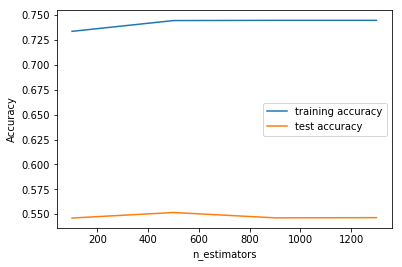

In [28]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


<hr>

### Tuning max_features

Let's see how the model performance varies with ```max_features```, which is the maximum numbre of features considered for splitting at a node.

In [29]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24, 50,100,200]}

# instantiate the model
rf = RandomForestClassifier(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(features,labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [4, 8, 14, 20, 24, 50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [30]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/disks/user/anacon

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.086226,0.003354,0.006260,0.000264,4,{'max_features': 4},0.513369,0.481713,0.507143,0.518750,...,0.512761,0.019684,8,0.624861,0.645248,0.641981,0.640419,0.643096,0.639121,0.007302
1,0.129893,0.000536,0.006379,0.000058,8,{'max_features': 8},0.516043,0.484389,0.525000,0.534821,...,0.521149,0.020852,7,0.637581,0.650602,0.639527,0.656703,0.654919,0.647866,0.007882
2,0.194401,0.002368,0.006155,0.000102,14,{'max_features': 14},0.534759,0.492417,0.551786,0.567857,...,0.542388,0.027611,1,0.648962,0.654395,0.645550,0.663841,0.657372,0.654024,0.006406
3,0.257518,0.004750,0.006355,0.000167,20,{'max_features': 20},0.546346,0.477252,0.540179,0.542857,...,0.527039,0.025604,6,0.657666,0.661089,0.662503,0.668749,0.657149,0.661431,0.004179
4,0.306146,0.003818,0.006362,0.000122,24,{'max_features': 24},0.545455,0.490633,0.536607,0.519643,...,0.527931,0.021065,4,0.668378,0.658411,0.641535,0.667856,0.654249,0.658086,0.009901


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


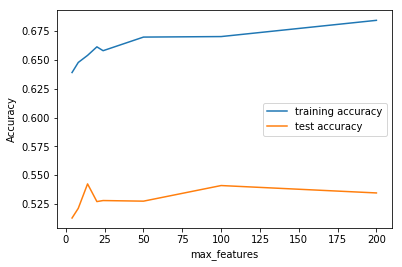

In [31]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Apparently, the training and test scores *both* seem to increase as we increase max_features, and the model doesn't seem to overfit more with increasing max_features. Think about why that might be the case.

## Grid Search to Find Optimal Hyperparameters

We can now find the optimal hyperparameters using GridSearchCV.

In [34]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10, 100, 224]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [35]:
# Fit the grid search to the data
grid_search.fit(features,labels)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/mnt/disks/user/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/mnt/disks/user/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/disks/user/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
  File "/mnt/disks/user/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/mnt/disks/user/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/disks/user/anaconda3/lib/python3.6/

KeyboardInterrupt: 

Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/mnt/disks/user/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/mnt/disks/user/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/mnt/disks/user/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/disks/user/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
KeyboardInterrupt
  File "/mnt/disks/user/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/disks/user/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()

In [ ]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

In [36]:
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=12,
                             max_features=0.7,
                             n_estimators=100,
                             criterion='gini',
                             class_weight='balanced'
                            )

In [37]:
# fit
rfc.fit(features,labels)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features=0.7,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Binary Base Model Evaluation

In [38]:
b_test_feature, b_test_labels = FeatureExtraction(b_test_X, b_test_set)

On image 0
On image 100
On image 200
On image 300
On image 400
On image 500
On image 600
On image 700
On image 800
On image 900
On image 1000
On image 1100
On image 1200
On image 1300
On image 1400
On image 1500
On image 1600
On image 1700
On image 1800
On image 1900
On image 2000
On image 2100
On image 2200
On image 2300


In [39]:
binary_y_pred = rfc.predict(b_test_feature)

In [40]:
Counter(binary_y_pred)

Counter({1: 1282, 0: 1115})

In [41]:
binary_score_test = metrics.accuracy_score(b_test_labels, binary_y_pred)
print('Base Model Test Score ',binary_score_test)

Base Model Test Score  0.6253650396328744


In [42]:
binary_cm = confusion_matrix(b_test_labels, binary_y_pred)
print(binary_cm)

[[708 491]
 [407 791]]


In [43]:
binary_report = classification_report(b_test_labels,binary_y_pred)
print(binary_report)

             precision    recall  f1-score   support

          0       0.63      0.59      0.61      1199
          1       0.62      0.66      0.64      1198

avg / total       0.63      0.63      0.62      2397



In [44]:
roc_auc_score(b_test_labels, binary_y_pred)

0.6253795942918486

## Multi-Class Base Classification Models

In [45]:
m_features, m_labels = FeatureExtraction(m_train_X, m_train_set)

On image 0
On image 100
On image 200
On image 300
On image 400
On image 500
On image 600
On image 700
On image 800
On image 900
On image 1000
On image 1100
On image 1200
On image 1300
On image 1400
On image 1500
On image 1600
On image 1700
On image 1800
On image 1900
On image 2000
On image 2100
On image 2200
On image 2300
On image 2400
On image 2500
On image 2600
On image 2700
On image 2800
On image 2900
On image 3000
On image 3100
On image 3200
On image 3300
On image 3400
On image 3500
On image 3600
On image 3700
On image 3800
On image 3900
On image 4000
On image 4100
On image 4200


In [46]:
m_rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=12,
                             max_features=0.7,
                             n_estimators=100,
                             criterion='gini',
                             class_weight='balanced'
                            )

In [48]:
m_rfc.fit(m_features,m_labels)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features=0.7,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

## Multi-Class ResNet SVM Model

In [49]:
m_test_feature, m_test_labels = FeatureExtraction(m_test_X, m_test_set)

On image 0
On image 100
On image 200
On image 300
On image 400
On image 500
On image 600
On image 700
On image 800
On image 900
On image 1000
On image 1100
On image 1200
On image 1300
On image 1400
On image 1500
On image 1600
On image 1700


In [50]:
multi_y_pred = m_rfc.predict(m_test_feature)

In [51]:
Counter(multi_y_pred)

Counter({2: 829, 1: 625, 0: 343})

In [52]:
multi_score_test = metrics.accuracy_score(m_test_labels, multi_y_pred)
print('Base Model Test Score ',multi_score_test)

Base Model Test Score  0.563717306622148


In [53]:
multi_cm = confusion_matrix(m_test_labels, multi_y_pred)
print(multi_cm)

[[180 189 230]
 [ 81 376 142]
 [ 82  60 457]]


In [54]:
multi_report = classification_report(m_test_labels,multi_y_pred)
print(multi_report)

             precision    recall  f1-score   support

          0       0.52      0.30      0.38       599
          1       0.60      0.63      0.61       599
          2       0.55      0.76      0.64       599

avg / total       0.56      0.56      0.55      1797



In [55]:
pkl_filename = "res_rf_binary.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rfc, file)

In [56]:
pkl_filename = "res_rf_multi.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(m_rfc, file)